In [1]:
from dask.distributed import Client
from dask_kubernetes.operator import KubeCluster
cluster = KubeCluster(name='cluster2', image='ghcr.io/patmagauran/mldocker-base:main',env={'EXTRA_CONDA_PACKAGES':'gcsfs'}, resources={"requests": {"memory": "6Gi"}, "limits": {"memory": "6Gi"}}  )
#cluster = KubeCluster.from_name(name="foo")
#cluster.adapt(minimum=4, maximum=8)
cluster.scale(5)

W1203 20:38:48.670012    7498 gcp.go:120] WARNING: the gcp auth plugin is deprecated in v1.22+, unavailable in v1.25+; use gcloud instead.
To learn more, consult https://cloud.google.com/blog/products/containers-kubernetes/kubectl-auth-changes-in-gke
W1203 20:38:59.973305    7533 gcp.go:120] WARNING: the gcp auth plugin is deprecated in v1.22+, unavailable in v1.25+; use gcloud instead.
To learn more, consult https://cloud.google.com/blog/products/containers-kubernetes/kubectl-auth-changes-in-gke


In [2]:
client = Client(cluster)
client

Unable to listen on port 8786: Listeners failed to create with the following errors: [unable to create listener: Error listen tcp4 0.0.0.0:8786: bind: address already in use]
error: unable to listen on any of the requested ports: [{8786 8787}]


<Client: 'tcp://10.56.1.2:8786' processes=5 threads=10, memory=30.00 GiB>

In [2]:
import numpy as np
import pandas as pd
import pyarrow as pa
import joblib
import dask.dataframe as dd
df = dd.read_parquet("gcs://ds352-data/anomaly-1").compute()

In [3]:
df['Date'] = df['Crash Month'].astype('str') + "/" + df['Day of Week'].astype('str') + "/" + df['Crash Year'].astype('str')

# Total Fatalities, Injuries, and Units

## Parametric Model

In [4]:
data = df
data.index = df['Date']
data = data.drop(['Date', 'Crash Month', 'Day of Week', 'Crash Year', 'Crash Record Number', 'Hour of Day', 'Person Count', 'Bicycle Count'],axis=1)
data.head()

,Fatality Count,Injury Count,Total Unit Count
Date,,,
6/4/2010,0,1,2
5/6/2009,0,1,2
7/3/1999,0,1,2
2/1/2005,0,1,2
9/4/2002,0,1,2


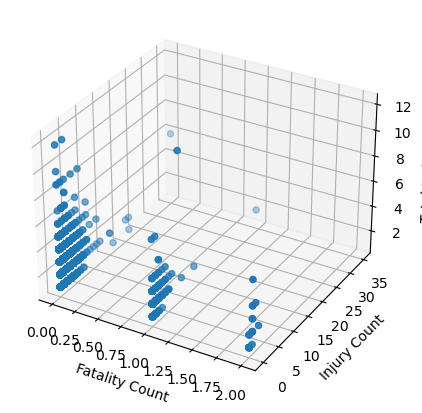

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d')
fig = fig.gca()
fig.scatter(data['Fatality Count'],data['Injury Count'],data['Total Unit Count'])
fig.set_xlabel('Fatality Count')
fig.set_ylabel('Injury Count')
fig.set_zlabel('Total Unit Count')
plt.show()


In [7]:
meanValue = data.mean()
covValue = data.cov()
print(meanValue)
print(covValue)

Fatality Count      0.009931
Injury Count        0.901292
Total Unit Count    1.898817
dtype: float64
                  Fatality Count  Injury Count  Total Unit Count
Fatality Count          0.010527     -0.003548          0.001080
Injury Count           -0.003548      0.558184          0.092284
Total Unit Count        0.001080      0.092284          0.295550


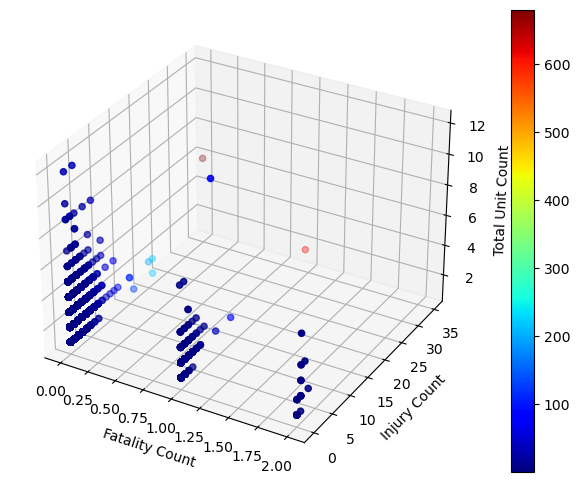

In [8]:
from numpy.linalg import inv

X = data.values
S = covValue.values
for i in range(3):
    X[:,i] = X[:,i] - meanValue[i]
    
def mahalanobis(row):
    return np.matmul(row,S).dot(row)   
    
anomaly_score = np.apply_along_axis( mahalanobis, axis=1, arr=X)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(data['Fatality Count'],data['Injury Count'],data['Total Unit Count'], c=anomaly_score,cmap='jet')
ax.set_xlabel('Fatality Count')
ax.set_ylabel('Injury Count')
ax.set_zlabel('Total Unit Count')
fig.colorbar(p)
plt.show()

In [9]:
anomUniv = pd.DataFrame(anomaly_score, index=data.index, columns=['Anomaly score'])
resultUniv = pd.concat((data,anomUniv), axis=1)
resultUniv.nlargest(5,'Anomaly score')

,Fatality Count,Injury Count,Total Unit Count,Anomaly score
Date,,,,
6/2/2004,0,35,6,679.796440
11/4/2000,1,34,2,611.902883
4/3/2003,0,21,2,225.862524
5/2/2010,0,21,1,222.388717
4/1/2004,0,20,2,203.964426


## Distance Based

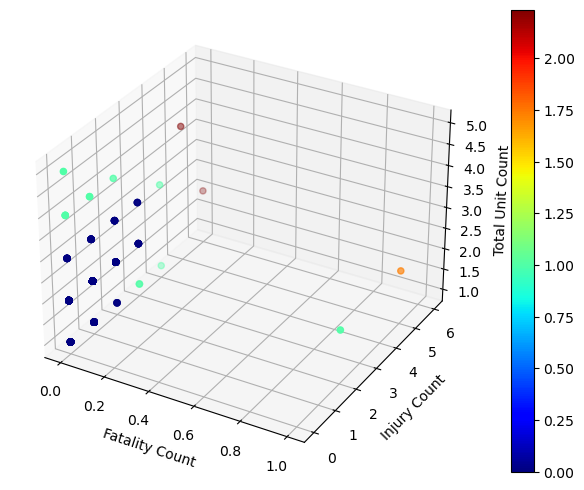

In [23]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial import distance
import joblib

knn = 4
data = dd.from_pandas(data, npartitions=5)
data = data.sample(frac=0.1)
#with joblib.parallel_backend('dask'):
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(data.values)
distances, indices = nbrs.kneighbors(data.values)

anomaly_score = distances[:,knn-1]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(data['Fatality Count'],data['Injury Count'],data['Total Unit Count'], c=anomaly_score,cmap='jet')
ax.set_xlabel('Fatality Count')
ax.set_ylabel('Injury Count')
ax.set_zlabel('Total Unit Count')
fig.colorbar(p)
plt.show()

In [25]:
anomUniv = pd.DataFrame(anomaly_score, index=data.index, columns=['Anomaly score'])
resultUniv = pd.concat((data.compute(),anomUniv), axis=1)
resultUniv.nlargest(5,'Anomaly score')

,Fatality Count,Injury Count,Total Unit Count,Anomaly score
6/7/1997,0,6,2,2.236068
8/2/2002,0,5,4,2.236068
10/5/2012,1,5,2,1.732051
10/3/2014,0,0,4,1.000000
12/2/2012,0,1,4,1.000000


In [17]:
client.close()

# Bike Crahses

In [5]:
data = df
data.index = df['Date']
data = data.drop(['Date', 'Crash Month', 'Day of Week', 'Crash Year', 'Crash Record Number', 'Hour of Day', 'Person Count', 'Fatality Count', 'Total Unit Count'],axis=1)
data.head()

,Injury Count,Bicycle Count
Date,,
6/4/2010,1,1
5/6/2009,1,1
7/3/1999,1,1
2/1/2005,1,1
9/4/2002,1,1


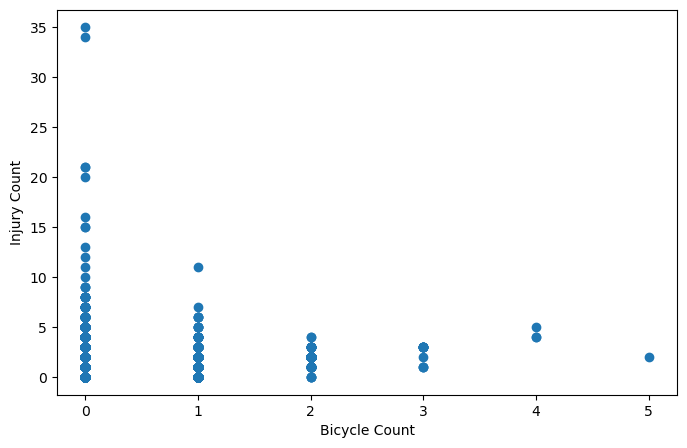

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(8,5))
fig = fig.gca()
fig.scatter(data['Bicycle Count'],data['Injury Count'])
fig.set_xlabel('Bicycle Count')
fig.set_ylabel('Injury Count')
plt.show()


In [29]:
meanValue = data.mean()
covValue = data.cov()
print(meanValue)
print(covValue)

Injury Count     0.901292
Bicycle Count    0.504075
dtype: float64
               Injury Count  Bicycle Count
Injury Count       0.558184       0.070299
Bicycle Count      0.070299       0.258953


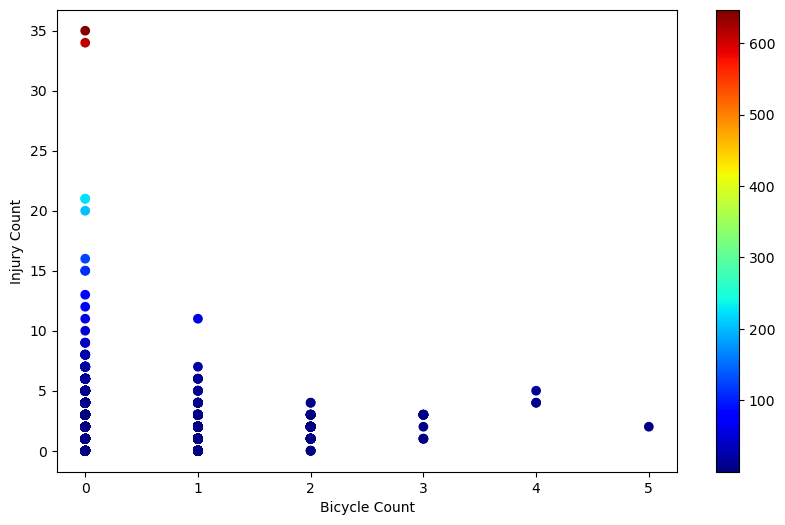

In [35]:
from numpy.linalg import inv

X = data.values
S = covValue.values
for i in range(2):
    X[:,i] = X[:,i] - meanValue[i]
    
def mahalanobis(row):
    return np.matmul(row,S).dot(row)   
    
anomaly_score = np.apply_along_axis( mahalanobis, axis=1, arr=X)

fig = plt.figure(figsize=(10,6))
fig = fig.gca()
p = fig.scatter(data['Bicycle Count'],data['Injury Count'], c=anomaly_score,cmap='jet')
fig.set_xlabel('Bicycle Count')
fig.set_ylabel('Injury Count')
plt.colorbar(p)
plt.show()

In [36]:
anomUniv = pd.DataFrame(anomaly_score, index=data.index, columns=['Anomaly score'])
resultUniv = pd.concat((data,anomUniv), axis=1)
resultUniv.nlargest(5,'Anomaly score')

,Injury Count,Bicycle Count,Anomaly score
Date,,,
6/2/2004,35,0,646.661363
11/4/2000,34,0,609.223744
4/3/2003,21,0,224.124102
5/2/2010,21,0,224.124102
4/1/2004,20,0,202.315622


## Std Dev

In [6]:
data = df
data.index = df['Date']
data = data.drop(['Date', 'Crash Month', 'Day of Week', 'Crash Year', 'Crash Record Number', 'Hour of Day', 'Person Count', 'Fatality Count', 'Total Unit Count', 'Injury Count'],axis=1)
data.head()


,Bicycle Count
Date,
6/4/2010,1
5/6/2009,1
7/3/1999,1
2/1/2005,1
9/4/2002,1


<AxesSubplot: >

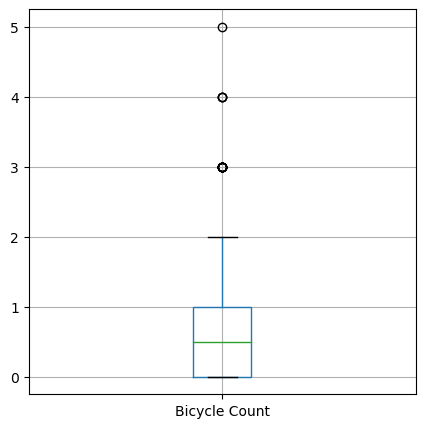

In [7]:
data.boxplot(figsize=(5,5))

In [41]:
data['zscore'] = (data['Bicycle Count'] - df['Bicycle Count'].mean())/df['Bicycle Count'].std(ddof=0)

In [43]:
data.nlargest(5,'zscore')

,Bicycle Count,zscore
Date,,
10/6/1997,5,8.835116
1/5/2009,4,6.869977
6/1/2016,4,6.869977
7/1/2009,4,6.869977
3/5/2012,3,4.904839
